# Minor-Embedding a Problem

**By Walid El Maouaki**

If we got a problem to optimize and we want to work on the D-Wave hardware, first of all we need to make sure that our problem is formulated as a **Binary Quadratic Model (BQM)**; one of those Models are:

* Quadratic Unconstrained Binary Optimization (QUBO): quadratic equation with binary 0/1 variables $$H(x)=\sum_{i} Q_{i, i} x_{i}+\sum_{i<j} Q_{i, j} x_{i} x_{j} \quad \text{where}\;\; x_{i}, x_{j} \in\{0,1\}\quad\quad (eq1)$$

* Ising Model (IM): quadratic equation with spin +1/-1 variables.The energy of a given configuration $s=s_1 \dots s_n$ (e.g: $s=+1,-1, \dots, -1$) is defined by: $${H(s)=\sum_{i} h_{i} s_{i}+ \sum_{i<j} J_{i, j} s_{i} s_{j} \quad \text{where}\;\; s_{i}, s_{j} \in\{-1,1\}\quad\quad (eq2)}$$

(Because in quantum mechanics, the Hamiltonian is not a function of variables, but of operators. We can write the same Hamiltonian in a quantum mechanical form: $$H_{I} |\psi\rangle=\left(\sum_{i \in V} h_{i} \sigma_{i}^{z}+\sum_{(i, j) \in E} J_{i j} \sigma_{i}^{z} \sigma_{j}^{z}\right)|\psi\rangle$$
Where the spin configuration is encoded in the state $|\psi\rangle$. The expectation value $\langle \psi |H|\psi \rangle$ of the Hamiltonian is the energy of the system, hence we should find the right configuration, quantum state, $|\psi\rangle$ to get the lowest value of that energy.)

The D-Wave QPU can be viewed as a heuristic that minimizes Ising objective functions using a physically realized version of quantum annealing. If our problem is formulated as an IM problem then it is in a native form, it can be submitted to the front end to be loaded onto the quantum annealing chip for a direct solution in hardware, that is, the weights $h_i$ and $J_{ij}$ correspond to electronic signals called biases that are applied to the qubits and to the couplings that connect pairs of qubits. The qubits work as quantum particles in a quantum annealing process to find a low-energy state that corresponds to a low-cost solution to the objective function. If the problem is not in native form e.g its expressed as the QUBO model, the software tools translate it into a native problem, so that an optimal solution to the translated problem yields an optimal solution to the original problem. Transformation of a general optimization problem instance to a native instance is a two-step process: first, translate the problem to the Ising Model: If we replace the $x$ terms in eq1 by $x=\frac{1-s}{2}$ we can go from the QUBO formulation to the Ising formulation eq2 [(see this)](https://support.dwavesys.com/hc/en-us/community/posts/360017439853-Difference-between-BQM-Ising-and-QUBO-problems-), and second, map the general IM connectivity graph to the hardware working graph.

A problem which is formulated or translated to the IM becomes a problem of the eq2 weights, a non zero $J_{ij}-$the edges and $h_i -$the vertices, define a problem graph as shown in the below figure1:

<img src="graph.jpg"  alt="A problem graph" style="width: 350px;"/>
By using `networkx` tool to plot that graph, we get:

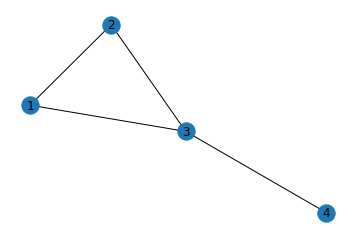

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
S = nx.Graph()
S.add_nodes_from([1,2,3,4])
S.add_edges_from([(1,2),(1,3),(2,3),(3,4)])
plt.axis('off')
nx.draw_networkx(S, with_labels=True)

The Ising Model problem concerns a collection of $n$ particles arranged on the vertices of a graph $G=(V, E)$, which is often assumed to be a $d$ -dimensional grid. Each particle can be in one of two states (spins) represented by $\pm 1$. A spin configuration $s=s_{1} \ldots s_{n}$ is an assignment of spin values to particles.

The next step is to run this problem on the D-Wave hardware, but there is a restriction imposed by the hardware design. The $h_i$ and $J_{ij}$ weights must match the physical connectivity structure on the chip. Qubit connectivity is based on a Chimera structure denoted $C_k$.

For instance, for many generations of the quantum annealer that D-Wave Systems produces has unit cells containing a $K_{4,4}$ bipartite fully-connected graph, with two remote connections from each qubit going to qubits in neighboring unit cells. Each qubit has 6 couplers, 4 within and 2 between unit cells. A unit cell with its local and remote connections indicated is depicted following figure2:

### Chimera graph embedding

P.S. I used the jupyter notebook provided by D-Wave to run those samples.

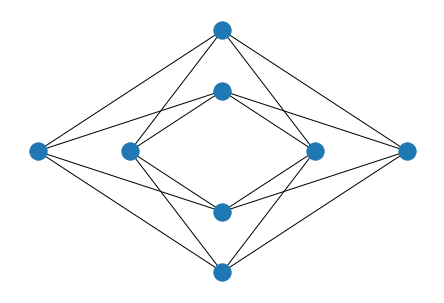

In [ ]:
import matplotlib.pyplot as plt
import dwave_networkx as dnx
%matplotlib inline

connectivity_structure_c = dnx.chimera_graph(1, 1)
dnx.draw_chimera(connectivity_structure_c)
plt.show()

The D-Wave QPU is based on a physical lattice of qubits and couplers referred to as the Chimera (another one is a Pegasus architecture). The number of spins depends on the number of qubits in the QPU. The current largest hardware has 2048 qubits, consisting of $16\times 16$ matrix of unit cells of 8 qubits.

Then we need to embed our problem in figure1 into the figure2 graph, the challenge is that figure1 has a triangle whereas the Chimera unit cell (figure2) has not, there is no way to set up 3 qubits in a closed loop to achieve the triangle graph configuration. So the idea is to represent a vertex by multiple qubits-they are called **physical qubits**- in figure2, we end up with a so called **logical qubit**, so a vertex get maps to a chain of qubits. This is called finding a minor embedding.

The Ocean's `minorminer` is a tool for finding graph minor-embeddings, developed to embed Ising problems onto quantum annealers, where it can be used to find minors in arbitrary graphs. Let us import it and use it find an embedding to our graph problem in figure1:

In [ ]:
import minorminer
embedded_graph_1 = minorminer.find_embedding(S.edges(), connectivity_structure_1.edges()) # Find an ebedding to our problem.

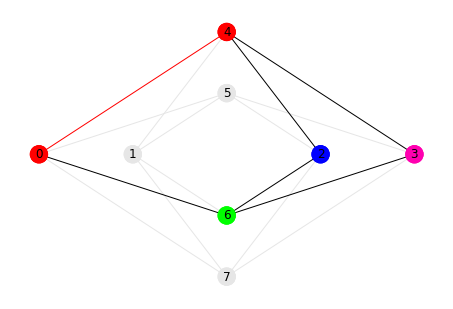

In [ ]:
dnx.draw_chimera_embedding(connectivity_structure_c, embedded_graph_1, with_labels=True)
plt.show()

Remark: MinorMiner tool can return different embedding,  and for complicated problem, it can return another connection graph that could be more optimal than the one returned at first try.

**As we can see the two physical qubits with the same color get coupled to represent one logical qubit. Qubits combined in such a way form a chain. To realize this coupling on the hardware we need a ferromagnetic coupling to push those two qubits taking the same result-apply an external magnetic field to align both spins in the same direction.**

**This formed chain has a strength which ensures that it will not be broken during the annealing process.**

- *Formulation of the Ising Problem as a QUBO*: In computer science, it is often more convenient to model with 0/1-valued variables than the −1/+1-valued Ising variables.

    While the Ising and QUBO expressions are isomorphic, the choice of spin or binary can affect the way the problem can be expressed; namely, QUBOs can always be fully expressed in both expanded and matrix forms, while Ising can be fully expressed in the expanded form, but not completely in the matrix form.
    
    And at the same time there are problems that get better results when formulated with IM.

Now let us find a solution for that particular problem (in figure1) using both QUBO model and IM:

* USING QUBO MODEL: WE ASSIGN FOR EACH EDGE (E) A VALUE
    we are going to use the above embedding to find a solution

In [ ]:
from dwave.system.samplers import DWaveSampler
from dwave.system import FixedEmbeddingComposite

E={(1,2):-1,(1,3):2,(2,3):-2,(3,4):1} # Represent the connections between the qubits; defined as Q_{i,j} in eq1 and J_{i,j} eq2

# Feed in the embedded graph and solve using QUBO model.
Result_qubo = FixedEmbeddingComposite(DWaveSampler(), embedded_graph_1).sample_qubo(E, chain_strength=4, num_reads=100)
# I guessed the chain_strength to be 4, try with another value and the result may not be the lowest energy.

for smpl, energy in Result_qubo.data(['sample', 'energy']):
    print(smpl,energy)

{1: 0, 2: 1, 3: 1, 4: 0} -2.0


I guessed 4 as a chain coupling strength because it is a stronger value than the other couplers around it, which forces the 2 qubits to be equal ($J<<0$, return to a ferromagnetic property which tells that the qubits are aligned in the same direction).

The lower energy that corresponds to the connection I give E, is -2.0.

* USING ISING MODEL: WE ASSIGN FOR EACH EDGE (E) AND FOR EACH MAGNETIC FIELD APPLIED TO THE QUBITS (h_i) A VALUE

In [ ]:
h_i={1:0,2:0,3:0,4:0} # Retuns to the weight h_i in equation 2

Result_ising = FixedEmbeddingComposite(DWaveSampler(), embedded_graph_1).sample_ising(h_i, E, num_reads=100)

for smpl, energy in Result_ising.data(['sample', 'energy']):
    print(smpl,energy)

{1: -1, 2: 1, 3: 1, 4: -1} -4.0
{1: 1, 2: -1, 3: -1, 4: 1} -4.0
{1: -1, 2: -1, 3: 1, 4: -1} -2.0
{1: 1, 2: 1, 3: 1, 4: 1} 0.0


**Remarkably, regarding the Ising solution, we found out that our problem has another lower energy -4.0 which is lower than the QUBO result, hence the IM is a better formulation for our problem.**

**This problem in figure1 can be thought of as finding the lowest energy spin configuration of a 2D spin-lattice, with the configuration that matches the lowest energy is $\{1: -1, 2: 1, 3: 1, 4: -1\}$ or $\{1: 1, 2: -1, 3: -1, 4: 1\}$ (where the sign of the ones define if the spin is Up or Down).**

### Pegasus graph embedding
In Pegasus, the actual structure of the unit cells has fundamentally changed for the first time. Instead of the Chimera graph where each qubit can have at most 6 qubits, the Pegasus graph allows each qubit to couple to 15 other qubits
    <img src="chimera vs pegasus.PNG"  alt="A problem graph" style="width: 450px;"/>
The picture is from [here](https://www.dwavesys.com/sites/default/files/mwj_dwave_qubits2018.pdf)

Using [pegasus_graph](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/reference/generated/dwave_networkx.pegasus_graph.html) we plot the Peagasus 2 graph using the D-Wave NetworkX.

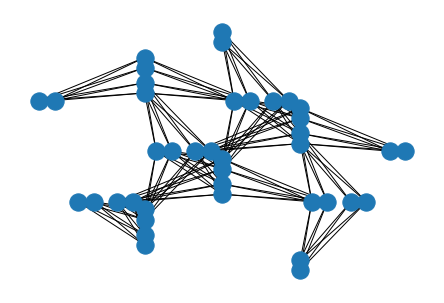

In [ ]:
connectivity_structure_p = dnx.pegasus_graph(2)
dnx.draw_pegasus(connectivity_structure_p)
plt.show()

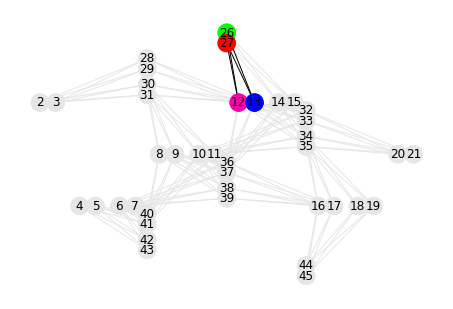

In [ ]:
import minorminer
embedded_graph_2 = minorminer.find_embedding(S.edges(), connectivity_structure_p.edges())
dnx.draw_pegasus_embedding(connectivity_structure_p, embedded_graph_2, with_labels=True)
plt.show()

**As we can see in the Pegasus embedding, for this particular problem, we are no more dealing with chain strength value! This new structure present an advantage regarding this latter and regarding the number of qubits.**

# $$\text{Optional}$$
### Another arbitrary problem that suits a $2\times 2$ unit cells version.

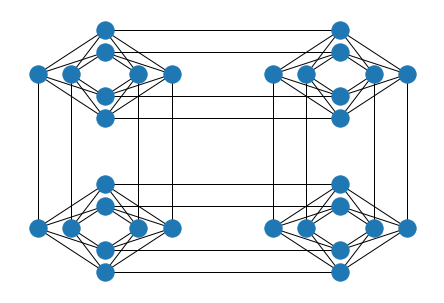

In [ ]:
import matplotlib.pyplot as plt
import dwave_networkx as dnx
%matplotlib inline

connectivity_structure = dnx.chimera_graph(2, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

Let's create a graph that certainly does not fit this connectivity structure. For instance, the complete graph $K_n$ on nine nodes:

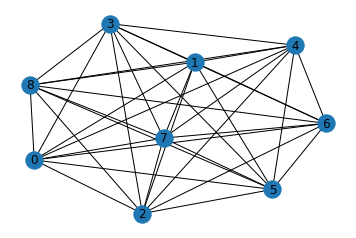

In [ ]:
import networkx as nx
G = nx.complete_graph(9)
plt.axis('off') 
nx.draw_networkx(G, with_labels=True)

In [ ]:
G.edges() # returns the connections between dots

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8)])

In [ ]:
import minorminer
embedded_graph = minorminer.find_embedding(G.edges(), connectivity_structure.edges())

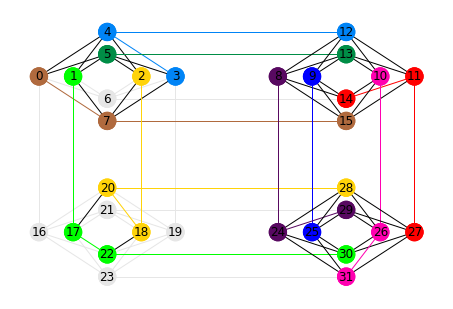

In [ ]:
dnx.draw_chimera_embedding(connectivity_structure, embedded_graph, with_labels=True)
plt.show()

Qubits that have the same colour corresponding to a logical node in the original problem defined by the $K_9$ graph. Qubits combined in such way form a chain. Even though our problem only has 9 variables (nodes), we used almost all 32 available on the toy Chimera graph.

To find a solution it turns out to have a different approach: first, there is `EmbeddingComposite` Which doesn't provide the embedded graph that was used. Second, `LazyFixedEmbeddingComposite` this one offers access to the embedding which has been used to find a solution. Later, `FixedEmbeddingComposite` use an embedding that you have found using ocean's minorminer, which as I mentioned return several possibilities of an embedding.

[In this issue](https://github.com/dwavesystems/dwave-system/issues/105), it show that `LazyEmbeddingComposite` uses minorminer and return the embedding dictionary which is considered as middle approach between `EmbeddingComposite` and `FixedEmbeddingComposite`.

Here I'm using the `FixedEmbeddingComposite` and `LazyEmbeddingComposite` to show an optimization result for the 9 nodes problem shown above.

## FixedEmbeddingComposite

In [ ]:
### ** This cell return an error : `ValueError: [25, 9] is not a connected chain` whereas in the embedded graph above
### we can see that the qubit 25 and 9 are connected!? **

# from dwave.system.samplers import DWaveSampler
# from dwave.system import FixedEmbeddingComposite

# Q={(0, 1):1, (0, 2):1, (0, 3):1, (0, 4):1, (0, 5):1, (0, 6):-2, (0, 7):2, (0, 8):2, (1, 2):2, (1, 3):-1, (1, 4):-1, 
#    (1, 5):-1, (1, 6):-1, (1, 7):-3, (1, 8):-3, (2, 3):-3, (2, 4):-3, (2, 5):-1, (2, 6):-2, (2, 7):1, (2, 8):1, (3, 4):1, 
#    (3, 5):1, (3, 6):-2, (3, 7):2, (3, 8):2, (4, 5):2, (4, 6):-2, (4, 7):-3, (4, 8):-2, (5, 6):-2, (5, 7):-2, (5, 8):-3, 
#    (6, 7):-3, (6, 8):-3, (7, 8):-3}
# # In the above, we show that minorminer find an embedding, but if we run it again it return another embedding so depending on
# # our choice we can feed the chosen graph in the `FixedEmbeddingComposite()`.
# Response = FixedEmbeddingComposite(DWaveSampler(), embedded_graph).sample_qubo(Q, num_reads=100) # Here I didn't choose a 
#                                               # chain strength value, because I did remark that it does not affect the result.

# for smpl, energy in Response.data(['sample', 'energy']):
#     print(smpl,energy)

## LazyFixedEmbeddingComposite

Here I'm showing a result by working the problem on both models the QUBO and Ising ones.

### sample_qubo

In [ ]:
from dwave.system import LazyFixedEmbeddingComposite
Q={(0, 1):1, (0, 2):1, (0, 3):1, (0, 4):1, (0, 5):1, (0, 6):-2, (0, 7):2, (0, 8):2, (1, 2):2, (1, 3):-1, (1, 4):-1, (1, 5):-1, 
   (1, 6):-1, (1, 7):-3, (1, 8):-3, (2, 3):-3, (2, 4):-3, (2, 5):-1, (2, 6):-2, (2, 7):1, (2, 8):1, (3, 4):1, (3, 5):1, 
   (3, 6):-2, (3, 7):2, (3, 8):2, (4, 5):2, (4, 6):-2, (4, 7):-3, (4, 8):-2, (5, 6):-2, (5, 7):-2, (5, 8):-3, (6, 7):-3, 
   (6, 8):-3, (7, 8):-3}


sampler=LazyFixedEmbeddingComposite(DWaveSampler())
response_2=sampler.sample_qubo(Q, num_reads=100)
print(sampler.properties['embedding']) #How to get the embedding

for smpl, energy in response_2.data(['sample', 'energy']):
    print(smpl,energy)

{0: [1741, 1609, 1737], 1: [1619, 1747, 1740, 1748], 2: [1614, 1611, 1739], 3: [1617, 1615, 1623], 4: [1618, 1746, 1742, 1750], 5: [1608, 1743, 1736], 6: [1616, 1612, 1620], 7: [1610, 1738], 8: [1613, 1621]}
{0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} -32.0
{0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} -32.0


### sample_ising

In [ ]:
h={0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}
response_3=sampler.sample_ising(h,Q, num_reads=100)
print(sampler.properties['embedding']) # Get the embedding dictionary.

for smpl, energy in response_3.data(['sample', 'energy']):
    print(smpl,energy)

{0: [1741, 1609, 1737], 1: [1619, 1747, 1740, 1748], 2: [1614, 1611, 1739], 3: [1617, 1615, 1623], 4: [1618, 1746, 1742, 1750], 5: [1608, 1743, 1736], 6: [1616, 1612, 1620], 7: [1610, 1738], 8: [1613, 1621]}
{0: 1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1} -39.0
{0: 1, 1: -1, 2: 1, 3: 1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1} -37.0
{0: -1, 1: 1, 2: -1, 3: -1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} -37.0
{0: 1, 1: -1, 2: 1, 3: 1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1} -37.0
{0: -1, 1: 1, 2: -1, 3: -1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} -37.0
{0: 1, 1: -1, 2: -1, 3: 1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1} -37.0
{0: 1, 1: 1, 2: -1, 3: -1, 4: -1, 5: 1, 6: 1, 7: 1, 8: 1} -25.0
{0: 1, 1: -1, 2: -1, 3: -1, 4: -1, 5: 1, 6: 1, 7: 1, 8: 1} -11.0
{0: -1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1, 6: 1, 7: -1, 8: 1} -7.0


## The role of the $h_i$ and $J_{i,j}$ weights in the IM.

Each variable corresponds to a physical Ising spin that can be in a +1 or −1 state with a local applied field on each spin that causes it to prefer either the +1 or −1 state. The sign and magnitude of this preference—that is, the value of the local field—is denoted $h_i$. There may also be couplings between spins i and j such that the system prefers the pair of spins to be in either of the two sets defined by si=sj (ferromagnetic coupling) or $s_i=−s_j$ (antiferromagnetic coupling). The sign and magnitude of this preference is denoted $J_{i,j}$.

* Then a negative $h_i$ weight means that the magnetic field points **Down** whereas a positive one the magnetic field point **Up**.
* And a negative $J_{i,j}$ weight mean that the coupling between the two spin leads them to take the same direction **Down  Down** or **Up Up** whereas a positive one leads the spins to point **Up Down** or **Down Up**.

Let's investigate the impact of the $h_i$ weight:

In [ ]:
h={0: -5, 1: -5, 2: -5, 3: -5, 4: -5, 5: -5, 6: -5, 7: -5, 8: -5} # All negative
response_4=sampler.sample_ising(h,Q, num_reads=100)
#print(sampler.properties['embedding']) # Get the embedding.

for smpl, energy in response_4.data(['sample', 'energy']):
    print(smpl,energy)

{0: -1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} -74.0
{0: -1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1} -74.0


In [ ]:
h={0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5} # All positive
response_5=sampler.sample_ising(h,Q, num_reads=100)

for smpl, energy in response_5.data(['sample', 'energy']):
    print(smpl,energy)

{0: 1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1} -74.0


## Summary
<img src="solution steps.PNG"  alt="A problem graph" style="width: 350px;"/>